## More text classification tasks, BERT fine-tuning, and model analysis

This notebook contains a couple more examples of NLP tasks, in addition to those shown in the lesson notebooks, that involve fine-tuning a pre-trained BERT model. They each involve some sort of binary or categorical labels, not text generation as the output. But the problem structure is slightly different for each task.

We'll try fine-tuning a couple different BERT models so that we can also include some of the basic types of analysis we'd expect to see in your projects. We not only want to look at a common overall evaluation metric to see which model works better, but try to understand the differences in the models' predictions to figure out why.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/datasci-w266/2022-fall-main/blob/master/materials/model_analysis/more_bert_tasks_and_model_analysis.ipynb)

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.8 MB/s 
     |████████████████████████████████| 7.6 MB 9.2 MB/s 
     |████████████████████████████████| 163 kB 15.6 MB/s 


In [2]:
import re
import json
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

from transformers import AutoTokenizer, TFAutoModel
from transformers import logging
logging.set_verbosity_error()  # skip warnings

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

For the models to compare, we'll try a couple of other pre-trained BERT model variants. [DistilRoBERTa](https://huggingface.co/distilroberta-base) is a smaller model than BERT base, with only six transformer blocks instead of 12.

[BERTweet](https://huggingface.co/docs/transformers/model_doc/bertweet) is a BERT model pre-trained on English Tweets. We're not using it for Twitter data in either task below, but one of the tasks involves short/informal text on a discussion platform (Github discussions about bugs and features). So there might be things about the language in that task that BERTweet will better recognize. We'll compare and see.

In [3]:
bert_model_names = ['distilroberta-base',
                    'vinai/bertweet-base']

tokenizers = [AutoTokenizer.from_pretrained(bert_model_name)
              for bert_model_name in bert_model_names]
bert_models = [TFAutoModel.from_pretrained(bert_model_name)
               for bert_model_name in bert_model_names]
bert_last_layer_num = [5, 11]

Downloading:   0%|          | 0.00/480 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/843k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/487M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/740M [00:00<?, ?B/s]

In [4]:
# Mount drive for saving model checkpoints, loading Task 2 data below

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Task 1: GLUE MRPC (Microsoft Research Paraphrase Corpus)

This dataset has pairs of sentences with labels indicating whether the two sentences are equivalent (i.e. they mean the same thing) or not. [GLUE dataset from tensorflow](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc). Code for using the data is based on [this code example here](https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert).

In [5]:
mrpc, mrpc_info = tfds.load('glue/mrpc', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3668 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/mrpc/2.0.0.incompleteZF9PIW/glue-train.tfrecord*...:   0%|          | 0/3…

Generating validation examples...:   0%|          | 0/408 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/mrpc/2.0.0.incompleteZF9PIW/glue-validation.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/1725 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/glue/mrpc/2.0.0.incompleteZF9PIW/glue-test.tfrecord*...:   0%|          | 0/17…

Dataset glue downloaded and prepared to ~/tensorflow_datasets/glue/mrpc/2.0.0. Subsequent calls will reuse this data.


In [6]:
# The data comes pre-split
mrpc

{Split('train'): <PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(), dtype=tf.string, name=None)}>,
 Split('validation'): <PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(), dtype=tf.string, name=None)}>,
 Split('test'): <PrefetchDataset element_spec={'idx': TensorSpec(shape=(), dtype=tf.int32, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentence1': TensorSpec(shape=(), dtype=tf.string, name=None), 'sentence2': TensorSpec(shape=(), dtype=tf.string, name=None)}>}

In [7]:
# The data includes pairs of sentences with a label for each
mrpc_info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [8]:
# Here are the labels
mrpc_info.features['label'].names

['not_equivalent', 'equivalent']

In [9]:
# There are 3668 training examples and 408 validation examples
mrpc_train_data = next(iter(mrpc['train'].batch(3668)))
mrpc_valid_data = next(iter(mrpc['validation'].batch(408)))

In [10]:
# Look at the first few examples in the data
for i in range(4):
  print()
  for key, value in mrpc_train_data.items():
      print(f"{key:9s}: {value[i].numpy()}")


idx      : 1680
label    : 0
sentence1: b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2: b'The rovers act as robotic geologists , moving on six wheels .'

idx      : 1456
label    : 0
sentence1: b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed ."
sentence2: b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is complete , assuming those businesses aren 't sold ."

idx      : 3017
label    : 1
sentence1: b'Spider-Man snatched $ 114.7 million in its debut last year and went on to capture $ 403.7 million .'
sentence2: b'Spider-Man , rated PG-13 , snatched $ 114.7 million in its first weekend and went on to take in $ 403.7 million .'

idx      : 2896
label    : 1
sentence1: b"The 2002 second quarter results don 't include figures from our friends at Compaq ."
sentence2: b'The year-ago numbers do not in

In [10]:
# Define a function to preprocess the data, which takes a tokenizer and dataset

def preprocess_mrpc(data, tokenizer, max_length):
    sents1 = data['sentence1'].numpy()
    sents2 = data['sentence2'].numpy()

    sentence_pairs = [(sents1[i].decode(), sents2[i].decode())
                          for i in range(sents1.shape[0])]
    encoded = tokenizer.batch_encode_plus(
            sentence_pairs,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="tf"
        )

    return [encoded["input_ids"],
            encoded["attention_mask"],
            encoded["token_type_ids"]], data['label']

In [11]:
# Define the function to build our MRPC model. It takes a pretrained bert model,
# freezes all layers except the last transformer block, then averages the
# BERT token embeddings and passes them to a binary classification layer.

def build_mrpc_model(bert_model, max_length, last_layer_num):
    # Freeze all but the last transformer block of the given bert model
    for w in bert_model.weights:
        if 'layer_._%s' % last_layer_num not in w.name:
            w._trainable = False

    input_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')
    
    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    cls_output = bert_output[0][:, 0, :]

    dropout_output = keras.layers.Dropout(0.3)(cls_output)
    final_output = keras.layers.Dense(1, activation="sigmoid")(dropout_output)
    
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [12]:
# It's a good idea to save model checkpoints as you train them.
# Edit this filepath to a place in your own Drive where you want to save them.

checkpoint_dir = 'drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/model_checkpoints/'

In [57]:
# Now train each model, and store the trained models in a dict for later analysis

max_length = 128

mrpc_models = {}
for i in range(len(bert_model_names)):
  
    mrpc_train_inputs, mrpc_train_labels = preprocess_mrpc(
        mrpc_train_data, tokenizers[i], max_length)
    mrpc_valid_inputs, mrpc_valid_labels = preprocess_mrpc(
        mrpc_valid_data, tokenizers[i], max_length)
    
    sample_weight = np.ones(shape=(len(mrpc_train_labels),))
    for label in range(np.max(mrpc_train_labels)+1):
        class_weight = 1 - np.sum(mrpc_train_labels == label) / len(mrpc_train_labels)
        sample_weight[mrpc_train_labels == label] = class_weight
    
    checkpoint_prefix = checkpoint_dir + 'mrpc_weights_%s' % bert_model_names[i].split('-')[0].split('/')[0]
    checkpoint_filepath = checkpoint_prefix + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True
    )
    
    mrpc_models[bert_model_names[i]] = build_mrpc_model(
        bert_models[i],
        max_length,
        bert_last_layer_num[i]
    )
    mrpc_models[bert_model_names[i]].fit(
        mrpc_train_inputs,
        mrpc_train_labels,
        sample_weight=sample_weight,
        validation_data=[mrpc_valid_inputs, mrpc_valid_labels],
        epochs=4,
        callbacks=[model_checkpoint_callback]
    )

Epoch 1/4


115/115 [==============================] - 30s 225ms/step - loss: 0.2947 - accuracy: 0.5976 - val_loss: 0.5362 - val_accuracy: 0.7402
Epoch 2/4
115/115 [==============================] - 25s 220ms/step - loss: 0.2455 - accuracy: 0.7126 - val_loss: 0.4743 - val_accuracy: 0.7794
Epoch 3/4
115/115 [==============================] - 26s 227ms/step - loss: 0.2115 - accuracy: 0.7653 - val_loss: 0.4496 - val_accuracy: 0.7647
Epoch 4/4
115/115 [==============================] - 27s 233ms/step - loss: 0.1884 - accuracy: 0.7947 - val_loss: 0.4351 - val_accuracy: 0.8039
Epoch 1/4


115/115 [==============================] - 59s 443ms/step - loss: 0.2694 - accuracy: 0.6614 - val_loss: 0.5150 - val_accuracy: 0.7402
Epoch 2/4
115/115 [==============================] - 48s 414ms/step - loss: 0.2150 - accuracy: 0.7634 - val_loss: 0.4688 - val_accuracy: 0.7941
Epoch 3/4
115/115 [==============================] - 43s 374ms/step - loss: 0.1798 - accuracy: 0.8105 - val_loss: 0.4908 - val_accuracy: 0.7672
Epoch 4/4
115/115 [==============================] - 43s 373ms/step - loss: 0.1569 - accuracy: 0.8359 - val_loss: 0.5387 - val_accuracy: 0.7647


The first model (distilroberta-base) got the highest overall validation accuracy after 4 epochs of training. The second model (bertweet) got close, but then started to overfit.

That said, when the scores are so close, it can be difficult to understand which model did better, how much and in what ways, just by looking at overall validation accuracy.

We'll dig into more metrics in the analysis section below. But first let's go through the second task, then we can do the same analysis on both.

### Task 2. Github Bugs Prediction Challenge (Machine Hack)

This dataset contains the titles and bodies of Github discussion posts, labeled with whether the post is about a bug, feature, or question. According to the documentation page, the labels are:
- Bug - 0
- Feature - 1
- Question - 2

The [data is available here](https://www.kaggle.com/datasets/arbazkhan971/github-bugs-prediction-challenge-machine-hack?resource=download). Download the data, upload to Google Drive, and mount your Drive to load the data.

For more exploration, [this blog post](https://www.analyticsvidhya.com/blog/2020/10/simple-text-multi-classification-task-using-keras-bert/) has similar code on fine-tuning a BERT model for this task and dataset.

In [13]:
# Edit this filepath to wherever you saved the data in your Drive
filepath = 'drive/MyDrive/ISchool/MIDS/W266/2022_Fall/notebooks/embold_train.json'

with open(filepath, 'r') as f:
    github_data = json.load(f)

In [14]:
df_github = pd.DataFrame(github_data)
df_github.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


In [22]:
df_github['label'].unique()

array([1, 0, 2])

In [23]:
len(df_github)

150000

In [15]:
# For speed to focus on comparing models, we'll just use 10k training examples and
# 1k validation (always shuffling first). You can explore using more on your own.

df_github = df_github.sample(frac=1)
df_github_train = df_github[0:10000]
df_github_valid = df_github[10000:11000]

In [16]:
# Define a function to preprocess the data, which takes a tokenizer and dataset

def preprocess_github(df, tokenizer, max_length):
    titles = df['title'].values
    bodies = df['body'].values

    text_pairs = [(titles[i], bodies[i])
                  for i in range(titles.shape[0])]
    encoded = tokenizer.batch_encode_plus(
            text_pairs,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="tf"
        )

    return [encoded["input_ids"],
            encoded["attention_mask"],
            encoded["token_type_ids"]], df['label'].values

In [17]:
# Define the function to build our Github model. It takes a pretrained bert model,
# freezes all layers except the last transformer block, then averages the
# BERT token embeddings and passes them to a binary classification layer.

def build_github_model(bert_model, max_length, last_layer_num=11):
    # Freeze all but layer_11 and pooler layers
    for w in bert_model.weights:
        if 'layer_._%d' % last_layer_num not in w.name:
            w._trainable = False

    input_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = keras.layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')
    
    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    cls_output = bert_output[0][:, 0, :]

    dropout_output = keras.layers.Dropout(0.3)(cls_output)
    final_output = keras.layers.Dense(3, activation="softmax")(dropout_output)
    
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [89]:
# Now train each model, and store the trained models in a dict for later analysis

max_length = 128

github_models = {}
for i in range(len(bert_model_names)):

    github_train_inputs, github_train_labels = preprocess_github(
        df_github_train, tokenizers[i], max_length)
    github_valid_inputs, github_valid_labels = preprocess_github(
        df_github_valid, tokenizers[i], max_length)
    
    sample_weight = np.ones(shape=(len(github_train_labels),))
    for label in range(np.max(github_train_labels)+1):
        class_weight = 1 - np.sum(github_train_labels == label) / len(github_train_labels)
        sample_weight[github_train_labels == label] = class_weight
    
    checkpoint_prefix = checkpoint_dir + 'github_weights_%s' % bert_model_names[i].split('-')[0].split('/')[0]
    checkpoint_filepath = checkpoint_prefix + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True
    )

    github_models[bert_model_names[i]] = build_github_model(
        bert_models[i],
        max_length,
        bert_last_layer_num[i]
    )
    github_models[bert_model_names[i]].fit(
        github_train_inputs,
        github_train_labels,
        sample_weight=sample_weight,
        validation_data=[github_valid_inputs, github_valid_labels],
        epochs=2,
        callbacks=[model_checkpoint_callback]
    )

Epoch 1/2


313/313 [==============================] - 66s 197ms/step - loss: 0.2377 - accuracy: 0.8478 - val_loss: 0.6934 - val_accuracy: 0.7570
Epoch 2/2
313/313 [==============================] - 64s 204ms/step - loss: 0.2265 - accuracy: 0.8549 - val_loss: 0.6675 - val_accuracy: 0.7880
Epoch 1/2


313/313 [==============================] - 120s 360ms/step - loss: 0.1772 - accuracy: 0.8919 - val_loss: 0.6835 - val_accuracy: 0.7830
Epoch 2/2
313/313 [==============================] - 115s 368ms/step - loss: 0.1643 - accuracy: 0.8992 - val_loss: 0.7951 - val_accuracy: 0.7880


It looks like BERTweet might have done better on this task, though again the scores are very close. In the next section, we'll break down the results more.

### Breaking Down Evaluation Metrics

Does the validation accuracy shown above give us enough info to simply pick a winning model? Is there more that we can try to understand about which model works better under what conditions, or what types of errors each one is making, so that we can learn how to use them and try to further improve them?

For instance, is one model missing more bugs or features than the other (in the Github data)? Is one over- or under-predicting paraphrase equivalence (in the MRPC data)? A good place to start is to look at precision and recall by label class, as well as a confusion matrix. We'll use the validation data for each task to do so.

In [58]:
def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = tf.math.confusion_matrix(y_true, y_pred)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    plt.figure(figsize=(20,7))
    sns.heatmap(
        cm, annot=True,
        xticklabels=label_names,
        yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")

distilroberta-base
13/13 [==============================] - 2s 131ms/step
              precision    recall  f1-score   support

           0       0.75      0.57      0.65       129
           1       0.82      0.91      0.86       279

    accuracy                           0.80       408
   macro avg       0.78      0.74      0.76       408
weighted avg       0.80      0.80      0.80       408

vinai/bertweet-base
13/13 [==============================] - 3s 255ms/step
              precision    recall  f1-score   support

           0       0.61      0.71      0.65       129
           1       0.85      0.79      0.82       279

    accuracy                           0.76       408
   macro avg       0.73      0.75      0.74       408
weighted avg       0.78      0.76      0.77       408



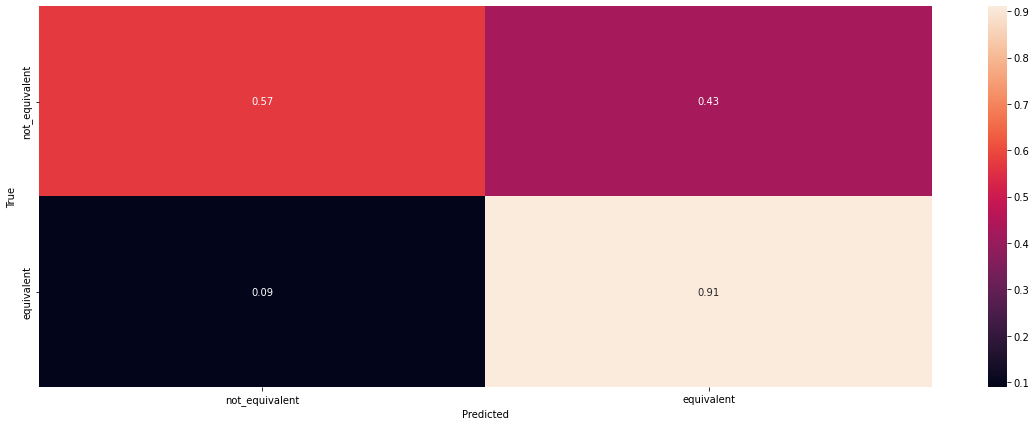

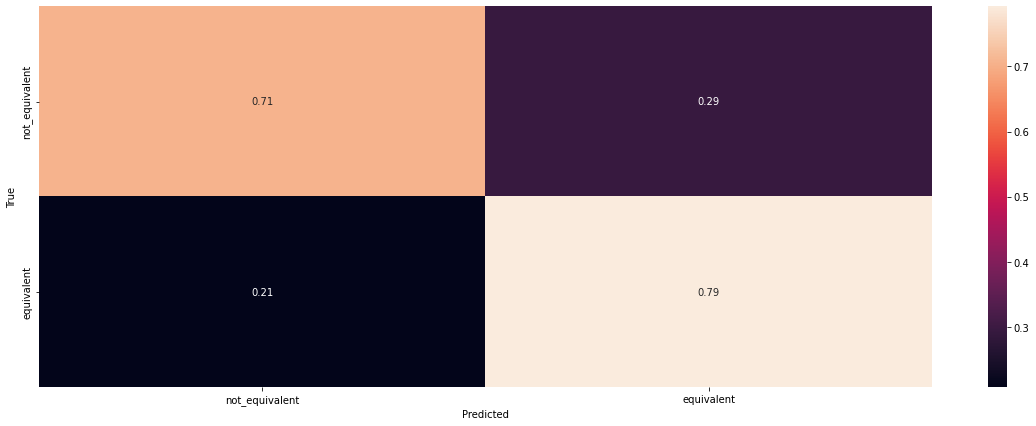

In [61]:
# Print classification report and confusion matrix for each model, for MRPC task.

mrpc_label_names = mrpc_info.features['label'].names

mrpc_wrong_guesses = {}  # Save indices of wrong guesses so we can look at them later

for i in range(len(bert_model_names)):
    print(bert_model_names[i])
    
    mrpc_valid_inputs, mrpc_valid_labels = preprocess_mrpc(
        mrpc_valid_data, tokenizers[i], max_length)

    mrpc_y_probs = mrpc_models[bert_model_names[i]].predict(mrpc_valid_inputs)
    mrpc_y_pred = np.squeeze(mrpc_y_probs >= 0.5)
    print(classification_report(mrpc_valid_labels, mrpc_y_pred))

    plot_confusion_matrix(mrpc_valid_labels, mrpc_y_pred, mrpc_label_names)

    mrpc_wrong_guesses[bert_model_names[i]] = np.where(mrpc_valid_labels != mrpc_y_pred)

The first model (distilroberta-base) does have higher f1 scores for this task, by label, macro and weighted average. You can see in the confusion matrix, though, that it is overpredicting that pairs of sentences are "equivalent" (which is why it has higher recall for label 1 and higher precision for label 0, which it is predicting less often). The second model (bertweet) has more balanced predictions.

I don't have a strong hypothesis for why that might be, but you might imagine some possibilities and try to explore them. For instance, maybe social media like Twitter tends to be domainated by more open disagreement than the books and Wikipedia text that a general-purpose BERT model like distilroberta was trained on. We'll look at some examples the models got wrong below, to see if we spot any patterns that differ between the models.

distilroberta-base
32/32 [==============================] - 6s 126ms/step
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       452
           1       0.80      0.83      0.82       456
           2       0.50      0.25      0.33        92

    accuracy                           0.79      1000
   macro avg       0.70      0.65      0.66      1000
weighted avg       0.77      0.79      0.78      1000

vinai/bertweet-base
32/32 [==============================] - 11s 247ms/step
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       452
           1       0.82      0.82      0.82       456
           2       0.48      0.47      0.47        92

    accuracy                           0.79      1000
   macro avg       0.71      0.70      0.70      1000
weighted avg       0.79      0.79      0.79      1000



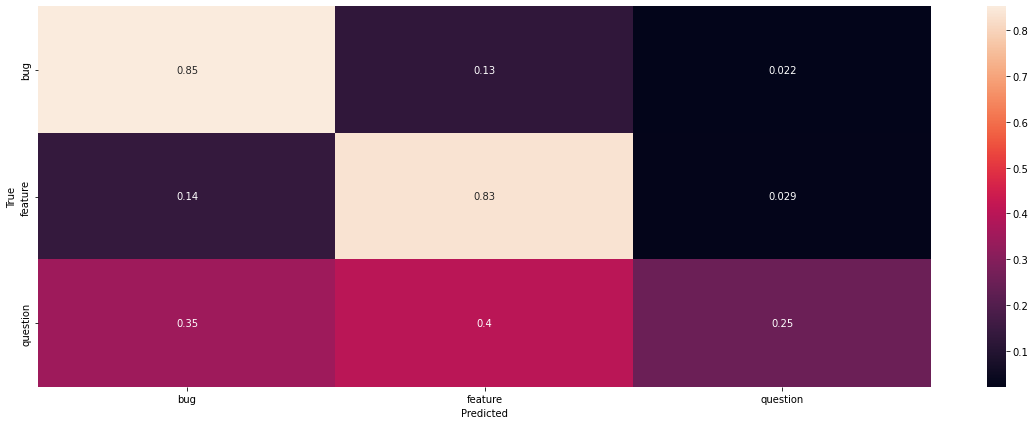

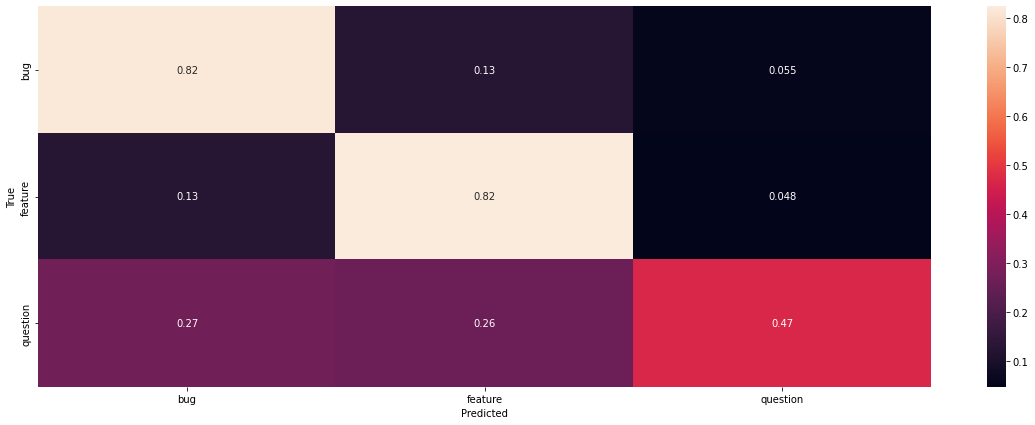

In [90]:
# Print classification report and confusion matrix for each model, for MRPC task.

github_label_names = ['bug', 'feature', 'question']

github_wrong_guesses = {}

for i in range(len(bert_model_names)):
    print(bert_model_names[i])
    
    github_valid_inputs, github_valid_labels = preprocess_github(
        df_github_valid, tokenizers[i], max_length)

    github_y_probs = github_models[bert_model_names[i]].predict(github_valid_inputs)
    github_y_pred = np.argmax(github_y_probs, axis=-1)
    print(classification_report(github_valid_labels, github_y_pred))

    plot_confusion_matrix(github_valid_labels, github_y_pred, github_label_names)

    github_wrong_guesses[bert_model_names[i]] = np.where(github_valid_labels != github_y_pred)

When breaking down metrics for the second task, bertweet looks like it might have done a bit better in both macro- and weighted-f1. Again, it seems to have done better on recall of the minority class (in this class, label 2, Github questions).

This might make us wonder if bertweet is handling imbalanced data better than distilroberta. In the code above, for both tasks, we included sample weights because the data is imbalanced. But that's not always enough; the extent to which a model tends to prefer predicting the majority class is often a result of how well it has been able to identify more useful patterns in the data.

There are really multiple differences between these two models. Not only were they pre-trained on different domains of text, they are also different sizes (bertweet is standard BERT sized, distilroberta is smaller). That might have enabled bertweet to pick up more nuance in the text connected to each label than distilroberta. Ideally in a thorough research project, you'd include models to compare each of these things separately (though it would have been a lot for this one notebook).

### Inspecting Misclassifications

It's always important to look at actual examples from our validation data, to see what mistakes the model is making. Below, we'll use the indices of the examples each model got wrong. We'll separate them into examples that only one model got wrong but not the other, as well as examples both models got wrong, and print out a sample from each to look at.

In [102]:
# MRPC: examples that the first model got right and the second got wrong

mrpc_examples_model1_better = [i for i in np.squeeze(mrpc_wrong_guesses[bert_model_names[1]])
                               if i not in np.squeeze(mrpc_wrong_guesses[bert_model_names[0]])]

for i in mrpc_examples_model1_better[:10]:
    print(mrpc_valid_data['sentence1'][i])
    print(mrpc_valid_data['sentence2'][i])
    print(mrpc_valid_data['label'][i])

tf.Tensor(b'It also offers a built-in NAND flash boot loader so that high-density NAND flash memory can be used without having to install an additional support chip .', shape=(), dtype=string)
tf.Tensor(b'The S3C2440 has a built-in NAND flash boot loader , for example , so that high-density NAND flash memory can be installed without an additional support chip .', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b"Dr Mark McClean , Jonathan 's family doctor , said if the drug had been administered earlier Jonathan would have retained more of his brain functions .", shape=(), dtype=string)
tf.Tensor(b"Dr Mark McClean , the family 's GP , said had the drug been administered to Jonathan earlier , he would have retained more of his brain function .", shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'The worm attacks Windows computers via a hole in the operating system , an issue Microsoft on July 16 had warned about .', shape=(), dtype=string)
tf.T

In [103]:
# MRPC: examples that the second model got right and the first got wrong

mrpc_examples_model2_better = [i for i in np.squeeze(mrpc_wrong_guesses[bert_model_names[0]])
                               if i not in np.squeeze(mrpc_wrong_guesses[bert_model_names[1]])]

for i in mrpc_examples_model2_better[:10]:
    print(mrpc_valid_data['sentence1'][i])
    print(mrpc_valid_data['sentence2'][i])
    print(mrpc_valid_data['label'][i])

tf.Tensor(b'The study , published Monday in the journal Molecular Brain Research , is likely to also apply to humans , its authors said .', shape=(), dtype=string)
tf.Tensor(b'The study , conducted on the brains of developing mice , was being published today in the journal Molecular Brain Research .', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'The Hartford shares rose $ 2.88 , or 6.6 percent , to close Monday at $ 46.50 on the New York Stock Exchange .', shape=(), dtype=string)
tf.Tensor(b'Shares of Hartford rose $ 2.88 to $ 46.50 in New York Stock Exchange composite trading .', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'One way or another , Harry Potter And The Order Of The Phoenix will be in your hands by Saturday .', shape=(), dtype=string)
tf.Tensor(b'Just about everything about " Harry Potter and the Order of the Phoenix " will set records .', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'Only one 

In [104]:
# MRPC: examples that both models got wrong

mrpc_examples_both_wrong = np.intersect1d(mrpc_wrong_guesses[bert_model_names[0]],
                                          mrpc_wrong_guesses[bert_model_names[1]])

for i in mrpc_examples_both_wrong[:10]:
    print(mrpc_valid_data['sentence1'][i])
    print(mrpc_valid_data['sentence2'][i])
    print(mrpc_valid_data['label'][i])

tf.Tensor(b"The show 's closure affected third-quarter earnings per share by a penny .", shape=(), dtype=string)
tf.Tensor(b'The company said this impacted earnings by a penny a share .', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'Witnesses said they believed the man planned to crash the Launceston-bound Qantas flight 1737 , which was carrying 47 passengers and six crew .', shape=(), dtype=string)
tf.Tensor(b'Witnesses believe he wanted to crash Flight 1737 , which had 47 passengers and six crew .', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'The jury verdict , reached Wednesday after less than four hours of deliberation , followed a 2 week trial , during which Waagner represented himself .', shape=(), dtype=string)
tf.Tensor(b'The quick conviction followed a 2 1 / 2 week trial , during which the Venango County man represented himself .', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(b'Gilead had earnings 

For the first task, most of the examples that the first model did better on are "equivalent" paraphrases, while the second model tended to do better on the "non-equivalent" pairs.

They both cover a variety of topics, so it doesn't look like either model is taking any obvious shortcuts, like thinking all sentence pairs about politics are non-equivalent.

In the examples model 1 did better on, it seems like model 2 does sometimes miss some easy ones, where the text between the two sentences is almost identical. But in the examples model 2 did better on, it seems like model 2 is better able to pick up on pairs of sentences that are very similar but labeled non-equivalent because one sentence has one little piece of extra info that the other sentence doesn't have.

In [110]:
# Github: examples that the first model got right and the second got wrong

github_examples_model1_better = [i for i in np.squeeze(github_wrong_guesses[bert_model_names[1]])
                                 if i not in np.squeeze(github_wrong_guesses[bert_model_names[0]])]

for i in github_examples_model1_better[:10]:
    print(df_github_valid['title'].values[i])
    print(df_github_valid['body'].values[i])
    print(df_github_valid['label'].values[i])

standalone binary for server+ffmpeg
hello,\r \r  i was very impressed by the speedup mentioned at https://www.freac.org/developer-blog-mainmenu-9/14-freac/257-introducing-superfast-conversions.  currently i run some video conversions on a server with ffmpeg.  the server does not have a graphical x environment.\r \r i would like to use this multi-threaded codec with ffmpeg if possible, either via a pipe or by splitting the audio and video, encoding the audio with this and video with ffmpeg.\r \r is this possible?\r \r failing this, is there a way to run freac in \ headless\  mode, and pass it commands via the console?\r \r \r thanks.
2
integrations  make whole integration item area clickable
only the blue area is clickable but the whole item area is highlighted when hovered by mouse.\r ! listclickablearea  https://user-images.githubusercontent.com/8707251/35922958-478ebfe6-0c1f-11e8-85ca-1ca8a3250c74.png \r \r this problem exists also on   home   and   customizations   pages.\r i can cr

In [111]:
# Github: examples that the second model got right and the first got wrong

github_examples_model2_better = [i for i in np.squeeze(github_wrong_guesses[bert_model_names[0]])
                                 if i not in np.squeeze(github_wrong_guesses[bert_model_names[1]])]

for i in github_examples_model2_better[:10]:
    print(df_github_valid['title'].values[i])
    print(df_github_valid['body'].values[i])
    print(df_github_valid['label'].values[i])

should fix the left shift on signed integer on random
in random there is a  << 11  step that carelessly shifts a signed integer, causing undefined behavior. this was discovered recently through the wonderful llvm undefined behavior sanitizer.\r \r apparently, just using unsigned integers works in this case.
0
new term request: superior-inferior ventricles\t
label: superior-inferior ventricles\t\r \r parent class id: hp_0011534\t\r parent label: abnormal spatial orientation of the cardiac segments\t\r \r suggested text def: an abnormality in which the heart ventricles are in a superior-inferior relationship due to abnormal displacement of the ventricular mass along the horizontal plane of its long axis; this frequently occurs together with criss-cross atrio-ventricular relationships.\r text def xref: mp:0011254\r \r see  mpo flyer spreadsheet  https://docs.google.com/spreadsheets/d/13sbaq55kesjyl32whw0o_bbseh1kpv082l_4cg04lgo/edit gid=33920039 \r \r
1
running https using defined certifi

In [112]:
# Github: examples that both models got wrong

github_examples_both_wrong = np.intersect1d(github_wrong_guesses[bert_model_names[0]],
                                            github_wrong_guesses[bert_model_names[1]])

for i in github_examples_both_wrong[:10]:
    print(df_github_valid['title'].values[i])
    print(df_github_valid['body'].values[i])
    print(df_github_valid['label'].values[i])

pokemon evolution animation is too short
device info\r ------------------\r - phone type: n/a\r - app version: 1.0.29\r \r steps to reproduce\r ----------------\r evolve a pokemon.\r \r actual behavior\r -----------------\r animation takes roughly 5 seconds. exp is awarded as expected.\r \r expected behavior\r ---------------\r evolution animation in official app takes 20-21 seconds. it is quite crucial since evolution of monster awards exp. too rapid evolution - too rapid exp gain - can be a reason for ban.\r \r other information\r ---------------\r one of methods to gain exp is to evolve a pokemon  500 exp for each evolvement . one of ways to power exp is to use lucky egg and evolve pokemons for half on hour. if evolution animation is so quick it might lead to crazy amounts of exp gained and can be easily detected as 3rd party app and therefore reason for ban.\r
0
cache  can't disable cache - post update issues
the cache option in performance seems to cause some issues with new posts

You can see that the text in the second task is very different from the text in the first. It's more informal, and there are a lot of first-person pronouns ("I"), on a discussion board like this. The language looks similar in both examples that model 1 did better on and examples that model 2 did better on. (Both sets have first person pronouns, some hyperlinks, abbreviations, etc.)

### Text attributes associated with differences in model errors

We might be able to identify patterns with some aggregate summary statistics, though. If bertweet is better at understanding the intent of short, informal text, maybe bertweet does even better than distilroberta on the shorter messages than the longer ones? Let's do this analysis on both tasks, and just take the average length of the examples that model 1 did better on, vs the average length of the examples that model 2 did better on.

In [118]:
mean_len_model1_better = np.mean([len(mrpc_valid_data['sentence1'].numpy()[i].split())
                                  + len(mrpc_valid_data['sentence2'].numpy()[i].split())
                                  for i in mrpc_examples_model1_better])
mean_len_model2_better = np.mean([len(mrpc_valid_data['sentence1'].numpy()[i].split())
                                  + len(mrpc_valid_data['sentence2'].numpy()[i].split())
                                  for i in mrpc_examples_model2_better])

print('Average length of paraphrase sentences when model 1 did better: %d' % mean_len_model1_better)
print('Average length of paraphrase sentences when model 2 did better: %d' % mean_len_model2_better)

Average length of paraphrase sentences when model 1 did better: 44
Average length of paraphrase sentences when model 2 did better: 42


In [119]:
mean_len_model1_better = np.mean([len(df_github_valid['title'].values[i].split())
                                  + len(df_github_valid['body'].values[i].split())
                                  for i in github_examples_model1_better])
mean_len_model2_better = np.mean([len(df_github_valid['title'].values[i].split())
                                  + len(df_github_valid['body'].values[i].split())
                                  for i in github_examples_model2_better])

print('Average length of github post when model 1 did better: %d' % mean_len_model1_better)
print('Average length of github post when model 2 did better: %d' % mean_len_model2_better)

Average length of github post when model 1 did better: 110
Average length of github post when model 2 did better: 73


That's a big difference! We don't see much difference in the first task, which has more consistent text length for pairs of sentences. But in the second task, the examples that model 1 did better on are much longer than the examples that model 2 did better on.

(If you measure length by characters, the examples model 1 did better on are almost twice the average length of the examples model 2 did better on. But I thought those numbers might be confusing, so I used a simple split on whitespace to get rough word lengths, shown here.)

There are probably other things about the text that bertweet is better able to handle, that we could try to measure. For instance, can we think of a simple way to tell which text is more informal or abbreviated? (E.g. contains more acronyms, or less stopwords like "a" and "the" that sometimes get left out of short github notes and social media posts?)

In [52]:
# Let's define a simple list of stopwords, just determiners and "be" verbs,
# that are sometimes left out of shorthand informal text on social media.
# We'll measure % of words that are in the list, so it isn't driven by overall length

stops = {'a', 'the', 'an', 'one', 'these', 'those', 'this', 'that',
         'is', 'was', 'are', 'were'}

def pct_stopwords(text):
    toks = re.findall('\w+', text.lower())
    return 100 * len([tok for tok in toks if tok in stops]) / len(toks)

pct_stopwords('This is a sentence with some stopwords in it.')

33.333333333333336

In [53]:
avg_stops_model1_better = np.mean([pct_stopwords(mrpc_valid_data['sentence1'].numpy()[i].decode())
                                   + pct_stopwords(mrpc_valid_data['sentence2'].numpy()[i].decode())
                                  for i in mrpc_examples_model1_better])
avg_stops_model2_better = np.mean([pct_stopwords(mrpc_valid_data['sentence1'].numpy()[i].decode())
                                   + pct_stopwords(mrpc_valid_data['sentence2'].numpy()[i].decode())
                                  for i in mrpc_examples_model2_better])

print('Avg pct stopwords in paraphrase sentences when model 1 did better: %d' % avg_stops_model1_better)
print('Avg pct stopwords in paraphrase sentences when model 2 did better: %d' % avg_stops_model2_better)

Avg pct stopwords in paraphrase sentences when model 1 did better: 23
Avg pct stopwords in paraphrase sentences when model 2 did better: 22


In [54]:
avg_stops_len_model1_better = np.mean([pct_stopwords(df_github_valid['title'].values[i])
                                       + pct_stopwords(df_github_valid['body'].values[i])
                                      for i in github_examples_model1_better])
avg_stops_len_model2_better = np.mean([pct_stopwords(df_github_valid['title'].values[i])
                                       + pct_stopwords(df_github_valid['body'].values[i])
                                      for i in github_examples_model2_better])

print('Avg pct stopwords in github post when model 1 did better: %d' % avg_stops_len_model1_better)
print('Avg pct stopwords in github post when model 2 did better: %d' % avg_stops_len_model2_better)

Avg pct stopwords in github post when model 1 did better: 15
Avg pct stopwords in github post when model 2 did better: 11


In task 2, it looks like in addition to model 1 (distilroberta) doing better on longer text, it also does better on text that has more determiners and "to be" words, which might be an indicator of more complete sentences or more formal text. Meanwhile, model 2 (bertweet) does better on text that has fewer of those types of stopwords in it, again which might be more similar to informal tweet text.

We don't see that difference as clearly in task 1, probably because the sentence pairs included in that task are generally all similarly complete sentences. They look like they're written at the typical level of formality of news and wikipedia, which is what model 1 was trained on.

This is just an example of some simple types of analysis that you can do, to try to understand the differences in models' performance on a specific task. You could represent these patterns in different ways, e.g. separating all validation examples that have certain vocabulary from examples that don't, then calculating model eval metrics for each subset. You might also spot other potential patterns in the misclassifications, or come up with other ideas about what differences in the text might relate to which model should perform better on it.